In [1]:
import numpy as np
import matplotlib.pyplot as plt
from run import agents, run_agent, AgentStats
from numpy.typing import NDArray
from typing import NamedTuple, Sequence, Tuple
from deepsea import MultiRewardsDeepSea
import multiprocessing as mp
from scipy.stats import t as tstudent
import pickle
import lzma
import seaborn as sns
from deepsea import MultiRewardsDeepSea
import pandas as pd
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

class Results(NamedTuple):
    training_rewards: NDArray[np.float64]
    greedy_rewards: Sequence[Tuple[int, NDArray[np.float64]]]
    regret: NDArray[np.float64]
    agent_stats: AgentStats
    
    
def CE(x, c=0.95):
    N = x.shape[0]
    alpha = c + (1-c)/2
    c = tstudent.ppf(alpha, N)
    s = np.std(x, axis=0, ddof=1)
    return x.mean(0), c * s/ np.sqrt(N)


/home/alessior/anaconda3/envs/bpirl/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
SIZES = [10, 15, 20, 30, 40, 50]
EPISODES = {10: 500, 15: 1000, 20: 1500, 30: 2500, 40:3500, 50: 4500}

raw_data = {}
data = {}
df = pd.DataFrame({
    'method': [],
    'size': [],
    'episodes': [],
    'avg_first_hit': [],
    'ce_first_hit': [],
    'probability_hit': [],
    'avg_rise_time': [],
    'ce_rise_time': [],
    'probability_rise_time': [],
    'avg_hit_time_lower_bound': [],
    'avg_rise_time_lower_bound': []
})

for size in SIZES:

    env = MultiRewardsDeepSea(size, enable_multi_rewards=False, slipping_probability=0.05)

    with lzma.open(f'data_{size}.pkl', 'rb') as f:
        raw_data[size] = pickle.load(f)
        for agent in raw_data[size].keys():
            res = np.array(raw_data[size][agent].training_rewards)
            
            if agent not in data: data[agent] = {}

            idxs = (res > 0).argmax(-1) #* size
            probability_hit_time =  len(idxs[idxs > 0]) / res.shape[0]

            NUM_RUNS = len(raw_data[size][agent].greedy_rewards)
            greedy_data = np.array([list(zip(*raw_data[size][agent].greedy_rewards[x]))[1] for x in range(NUM_RUNS)])

            mu_groups, std_groups = greedy_data.mean(-1), greedy_data.std(-1, ddof=1)
            RSS, ESS = std_groups.mean(0), mu_groups.std(0, ddof=1)
            mu, std = mu_groups.mean(0), RSS+ESS
            alpha = .95 + (1-.95)/2
            c = tstudent.ppf(alpha, NUM_RUNS)
            ce_greedy = c * std/ np.sqrt(NUM_RUNS)


            max_value = env.optimal_Q_values.max(-1)[0,0]
            rise_time = 0.7

            idxs_rise_time = (greedy_data.mean(-1) >= max_value * rise_time).argmax(-1) * 250 / size
            probability_rise_time =  len(idxs_rise_time[idxs_rise_time > 0]) / res.shape[0]
            
            avg_hit_time_lower_bound = CE(idxs[idxs > 0])[0] * probability_hit_time + (1-probability_hit_time) * EPISODES[size] 
            avg_hit_time_lower_bound = EPISODES[size]  if np.isnan(avg_hit_time_lower_bound) else avg_hit_time_lower_bound

            avg_rise_time_lower_bound = CE(idxs_rise_time[idxs_rise_time > 0])[0] * probability_rise_time + (1-probability_rise_time) * EPISODES[size] 
            avg_rise_time_lower_bound = EPISODES[size]  if np.isnan(avg_rise_time_lower_bound) else avg_rise_time_lower_bound

            data[agent][size] = {
                'first_hit': CE(idxs[idxs > 0]),
                'probability_of_hit': np.round(100 * probability_hit_time, 2),
                'mean_greedy': mu,
                'ce_greedy': ce_greedy,
                'greedy_data': greedy_data,
                'rise_time': CE(idxs_rise_time[idxs_rise_time > 0]),
                'rise_time_prop': CE(idxs_rise_time / (size * EPISODES[size])),
                'probability_rise_time': np.round(100 * probability_rise_time, 2),
                'avg_hit_time_lower_bound': avg_hit_time_lower_bound,
                'avg_rise_time_lower_bound': avg_rise_time_lower_bound
            }
            df.loc[len(df)] = [agent, size, EPISODES[size], data[agent][size]['first_hit'][0], data[agent][size]['first_hit'][1], data[agent][size]['probability_of_hit'], 
                               data[agent][size]['rise_time'][0], data[agent][size]['rise_time'][1], data[agent][size]['probability_rise_time'], data[agent][size]['avg_hit_time_lower_bound'],
                               data[agent][size]['avg_rise_time_lower_bound']]

            


data

/home/alessior/anaconda3/envs/bpirl/lib/python3.11/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/alessior/anaconda3/envs/bpirl/lib/python3.11/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/alessior/anaconda3/envs/bpirl/lib/python3.11/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1567307/658373418.py:28: RuntimeWarning: Mean of empty slice.
  return x.mean(0), c * s/ np.sqrt(N)
/home/alessior/anaconda3/envs/bpirl/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/alessior/anaconda3/envs/bpirl/lib/python3.11/site-packages/numpy/core/_methods.

{'boot_dqn_torch': {10: {'first_hit': (107.4, 18.002984522299787),
   'probability_of_hit': 100.0,
   'mean_greedy': array([-0.004, -0.005, -0.006, 0.077, 0.217, 0.416, 0.562, 0.589, 0.575,
          0.619, 0.582, 0.619, 0.628, 0.592, 0.655, 0.658, 0.565, 0.605,
          0.628, 0.672]),
   'ce_greedy': array([0.001, 0.001, 0.001, 0.158, 0.274, 0.357, 0.354, 0.354, 0.336,
          0.315, 0.340, 0.320, 0.320, 0.326, 0.315, 0.304, 0.331, 0.344,
          0.347, 0.300]),
   'greedy_data': array([[[-0.002, -0.001, -0.003, ..., -0.005, -0.001, -0.001],
           [-0.004, -0.006, -0.006, ..., -0.003, -0.005, -0.006],
           [-0.006, -0.006, -0.008, ..., -0.006, -0.006, -0.006],
           ...,
           [0.990, 0.991, 0.991, ..., 0.991, -0.006, 0.991],
           [0.990, 0.990, 0.990, ..., -0.004, -0.007, 0.990],
           [0.991, 0.990, -0.007, ..., 0.990, -0.007, 0.990]],
   
          [[-0.003, -0.003, -0.003, ..., -0.004, -0.003, -0.003],
           [-0.005, -0.005, -0.005, ..., 

In [5]:
grouped_df = df.groupby(['method'])
grouped_df.apply(lambda a: a[:])


method  size   
method                                                                          
boot_dqn_torch                    0                      boot_dqn_torch    10  \
                                  4                      boot_dqn_torch    15   
                                  7                      boot_dqn_torch    20   
                                  10                     boot_dqn_torch    30   
                                  13                     boot_dqn_torch    40   
                                  16                     boot_dqn_torch    50   
explorative_generative_off_policy 2   explorative_generative_off_policy    10   
                                  3   explorative_generative_off_policy    15   
                                  6   explorative_generative_off_policy    20   
                                  9   explorative_generative_off_policy    30   
                                  12  explorative_generative_off_policy    40   
                                  15  explorative_generative_off_policy    50   
ids                               1                                 ids    10   
                                  5                                 ids    15   
                                  8                                 ids    20   
                                  11                                ids    30   
                                  14                                ids    40   
                                  17                                ids    50   

                                      episodes  avg_first_hit  ce_first_hit   
method                                                                        
boot_dqn_torch                    0        500     107.400000     18.002985  \
                                  4       1000     304.714286     73.656432   
                                  7       1500     700.818182    139.716567   
                                  10      2500    1619.428571    375.728322   
                                  13      3500            NaN           NaN   
                                  16      4500            NaN           NaN   
explorative_generative_off_policy 2        500      76.400000     11.457078   
                                  3       1000     144.875000     27.189301   
                                  6       1500     295.875000     38.796234   
                                  9       2500     584.312500     55.851465   
                                  12      3500    1349.625000    101.434547   
                                  15      4500    2189.875000    241.172645   
ids                               1        500      76.666667     39.592725   
                                  5       1000            NaN           NaN   
                                  8       1500            NaN           NaN   
                                  11      2500            NaN           NaN   
                                  14      3500            NaN           NaN   
                                  17      4500            NaN           NaN   

                                      probability_hit  avg_rise_time   
method                                                                 
boot_dqn_torch                    0            100.00     123.333333  \
                                  4             87.50     441.666667   
                                  7             68.75     985.416667   
                                  10            43.75    2287.500000   
                                  13             0.00            NaN   
                                  16             0.00            NaN   
explorative_generative_off_policy 2            100.00      73.333333   
                                  3            100.00     200.000000   
                                  6            100.00     382.812500   
                                  9            100.00     778.125000   

In [16]:
NUM_RUNS = len(raw_data[10]['ids'].greedy_rewards)
greedy_data = np.array([list(zip(*raw_data[10]['ids'].greedy_rewards[x]))[1] for x in range(NUM_RUNS)])

mu_groups, std_groups = greedy_data.mean(-1), greedy_data.std(-1, ddof=1)
RSS, ESS = std_groups.mean(0), mu_groups.std(0, ddof=1)
mu, std = mu_groups.mean(0), RSS+ESS
alpha = .95 + (1-.95)/2
c = tstudent.ppf(alpha, NUM_RUNS)
CE = c * std/ np.sqrt(NUM_RUNS)

array([0.002, 0.002, 0.162, 0.300, 0.354, 0.376, 0.328, 0.371, 0.353,
       0.352, 0.346, 0.360, 0.365, 0.341, 0.396, 0.364, 0.360, 0.401,
       0.386, 0.365])

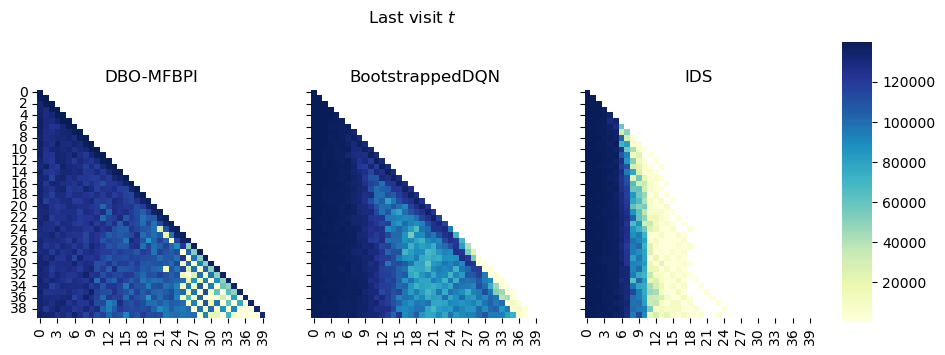

In [8]:
size = 40
fig, ax = plt.subplots(1,3,figsize=(10,4), sharey=True)
cbar_ax = fig.add_axes([.93, .2, .03, .7])
labels = {'explorative_generative_off_policy': 'DBO-MFBPI', 'boot_dqn_torch': 'BootstrappedDQN', 'ids': 'IDS'}

for agent_id, agent in enumerate(raw_data[size].keys()):
    last_visit = np.vstack([raw_data[size][agent].agent_stats[x].last_visit[None,...] for x in range(len(raw_data[size][agent].agent_stats))])
    last_visit = last_visit.mean(0)

   

    mask = np.zeros_like(last_visit, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Want diagonal elements as well
    mask[np.diag_indices_from(mask)] = False

    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    #cmap = sns.diverging_palette(100, 7, s=75, l=40, n=5, center="light", as_cmap=True)
    last_visit[np.isclose(0, last_visit)] = np.nan
    with sns.axes_style("white"):
        sns.heatmap(last_visit, square=True, cmap="YlGnBu",  ax=ax[agent_id], mask=mask, cbar_ax=cbar_ax, robust=True)
    ax[agent_id].set_title(labels[agent])

fig.suptitle('Last visit $t$')
plt.savefig(f'figures/last_visit_{size}.pdf')
plt.show()

/tmp/ipykernel_1422540/1644193227.py:21: RuntimeWarning: divide by zero encountered in log
  sns.heatmap(-frequency_visits * np.log(frequency_visits), square=True, cmap="YlGnBu",  ax=ax[agent_id], mask=mask, cbar_ax=cbar_ax, robust=True)
/tmp/ipykernel_1422540/1644193227.py:21: RuntimeWarning: invalid value encountered in multiply
  sns.heatmap(-frequency_visits * np.log(frequency_visits), square=True, cmap="YlGnBu",  ax=ax[agent_id], mask=mask, cbar_ax=cbar_ax, robust=True)
/tmp/ipykernel_1422540/1644193227.py:21: RuntimeWarning: divide by zero encountered in log
  sns.heatmap(-frequency_visits * np.log(frequency_visits), square=True, cmap="YlGnBu",  ax=ax[agent_id], mask=mask, cbar_ax=cbar_ax, robust=True)
/tmp/ipykernel_1422540/1644193227.py:21: RuntimeWarning: invalid value encountered in multiply
  sns.heatmap(-frequency_visits * np.log(frequency_visits), square=True, cmap="YlGnBu",  ax=ax[agent_id], mask=mask, cbar_ax=cbar_ax, robust=True)
/tmp/ipykernel_1422540/1644193227.py:21:

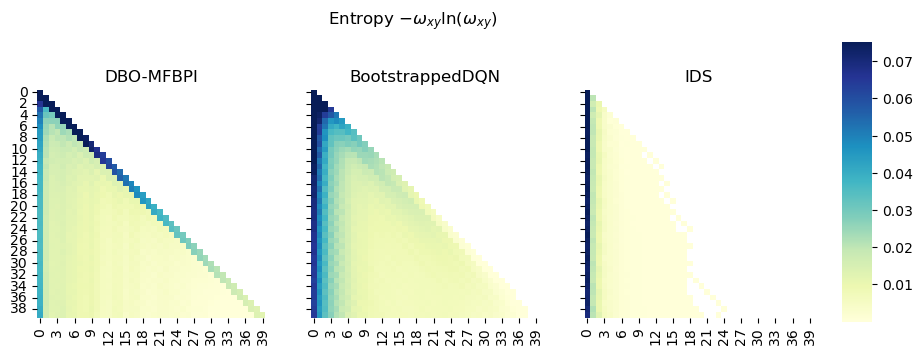

In [9]:
size = 40
fig, ax = plt.subplots(1,3,figsize=(10,4), sharey=True)
cbar_ax = fig.add_axes([.93, .2, .03, .7])
labels = {'explorative_generative_off_policy': 'DBO-MFBPI', 'boot_dqn_torch': 'BootstrappedDQN', 'ids': 'IDS'}

for agent_id, agent in enumerate(raw_data[size].keys()):
    frequency_visits = np.vstack([raw_data[size][agent].agent_stats[x].frequency_visits[None,...] for x in range(len(raw_data[size][agent].agent_stats))])
    frequency_visits = frequency_visits.mean(0)

   

    mask = np.zeros_like(frequency_visits, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Want diagonal elements as well
    mask[np.diag_indices_from(mask)] = False

    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    #cmap = sns.diverging_palette(100, 7, s=75, l=40, n=5, center="light", as_cmap=True)
    with sns.axes_style("white"):
        sns.heatmap(-frequency_visits * np.log(frequency_visits), square=True, cmap="YlGnBu",  ax=ax[agent_id], mask=mask, cbar_ax=cbar_ax, robust=True)
    ax[agent_id].set_title(labels[agent])

fig.suptitle(r'Entropy $-\omega_{xy} \ln(\omega_{xy})$')
plt.savefig(f'figures/frequency_visits_{size}.pdf')
plt.show()

array([[99961.000, nan, nan, ..., nan, nan, nan],
       [99951.333, 99772.667, nan, ..., nan, nan, nan],
       [99955.000, 99533.667, 99421.667, ..., nan, nan, nan],
       ...,
       [99984.667, 99686.000, 99171.333, ..., nan, nan, nan],
       [99983.000, 99777.667, 99353.667, ..., nan, nan, nan],
       [99976.000, 99730.667, 99549.333, ..., nan, nan, nan]])

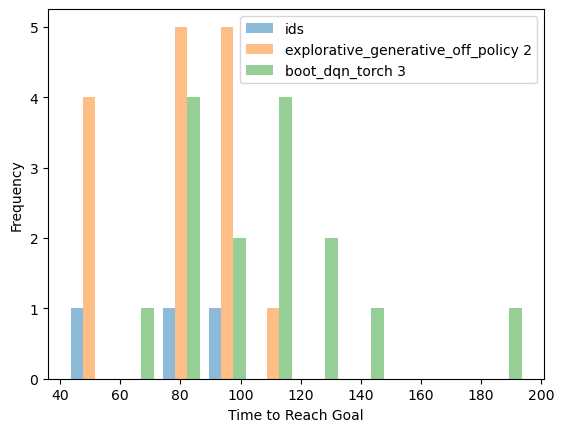

In [72]:
method1_times =data['ids'][10]['first_hit']
method2_times = data['explorative_generative_off_policy'][10]['first_hit']
method3_times = data['boot_dqn_torch'][10]['first_hit']

# Plot histogram
plt.hist([method1_times, method2_times, method3_times], bins=10, alpha=0.5, label=['ids', 'explorative_generative_off_policy 2', 'boot_dqn_torch 3'])
plt.xlabel('Time to Reach Goal')
plt.ylabel('Frequency')
plt.legend(loc='upper right')



plt.show()